# Stage 3: Winsorization, Neutralization & Rolling PCA

Structured workflow to build the stage-3 feature store on top of the cleaned cross-sectional features.

**Pipeline**
- Load cleaned factor features (already cross-sectionally standardized by teammates).
- Optional: re-run winsorization/z-score in case new features are added.
- Optional: size/industry neutralization via cross-sectional regressions.
- Rolling PCA on trailing windows to build a lower-dimensional feature store.
- Visual diagnostics (explained variance over time, PCA1 score distribution, loadings).

In [3]:

import numpy as np
import pandas as pd
from pathlib import Path
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_theme(style="whitegrid")
pd.set_option("display.max_columns", 10)

DATA_PATH = Path("data/cleaned/features_cleaned.pkl")
OUTPUT_DIR = Path("./")
OUTPUT_DIR.mkdir(exist_ok=True)


In [4]:

# 1) Load cleaned features
features = pd.read_pickle(DATA_PATH)
print(f"Loaded features: shape={features.shape}, unique dates={features.index.get_level_values('date').nunique()}")
features.head()


Loaded features: shape=(90846, 203), unique dates=212


abnormal_accruals_modified_jones  \
date       asset                                         
2007-01-31 000006.SZ                         -0.928545   
           000016.SZ                          0.626238   
           000028.SZ                         -0.229162   
           000040.SZ                         -1.230688   
           000042.SZ                          0.635659   

                      abnormal_capital_investment_ttm  abnormal_turnover_21  \
date       asset                                                              
2007-01-31 000006.SZ                         6.919926              0.618228   
           000016.SZ                        -0.200780             -0.017167   
           000028.SZ                        -0.007441             -0.437839   
           000040.SZ                        -0.361818              0.457078   
           000042.SZ                         0.251491              0.331737   

                      accrual_q_var  accrual_to_asset_mra  ...  \
date       asset                                           ...   
2007-01-31 000006.SZ      -2.737993             -0.109613  ...   
           000016.SZ       0.479815              0.656187  ...   
           000028.SZ      -0.485550             -1.306947  ...   
           000040.SZ       0.417872             -1.135431  ...   
           000042.SZ      -0.891424             -0.104173  ...   

                      west_eps_fy1_chg_1m  west_netprofit_fy1_1m  \
date       asset                                                   
2007-01-31 000006.SZ            -0.412028              -0.157250   
           000016.SZ             0.013904              -0.003330   
           000028.SZ             0.089963               0.072329   
           000040.SZ             0.000000               0.000000   
           000042.SZ            -2.336326              -1.133694   

                      west_stdeps_fy1  working_capital_to_asset  \
date       asset                                                  
2007-01-31 000006.SZ         2.459189                  0.546950   
           000016.SZ        -0.121118                  0.368192   
           000028.SZ        -0.619960                 -0.652915   
           000040.SZ         0.000000                  0.202568   
           000042.SZ         3.092238                 -0.027019   

                      zero_return_ratio_252  
date       asset                             
2007-01-31 000006.SZ              -0.832494  
           000016.SZ              -0.404951  
           000028.SZ              -0.924924  
           000040.SZ               0.438547  
           000042.SZ              -1.848765  

[5 rows x 203 columns]

In [5]:

# 2) Cross-sectional utilities

def winsorize_by_date(df: pd.DataFrame, lower: float = 0.01, upper: float = 0.99) -> pd.DataFrame:
    """Clip each feature within [lower, upper] quantiles per date to reduce tail risk."""
    def _winsorize(group: pd.DataFrame) -> pd.DataFrame:
        return group.apply(lambda s: s.clip(*s.quantile([lower, upper])), axis=0)
    return df.groupby(level="date", group_keys=False).apply(_winsorize)


def zscore_by_date(df: pd.DataFrame) -> pd.DataFrame:
    """Cross-sectional z-score per date with safe handling for zero-variance features."""
    def _z(group: pd.DataFrame) -> pd.DataFrame:
        mean = group.mean()
        std = group.std(ddof=0)
        std_repl = std.replace(0, 1)
        return (group - mean) / std_repl
    return df.groupby(level="date", group_keys=False).apply(_z)


def build_size_industry_exposures(df: pd.DataFrame, size_feature: str | None = "total_asset_to_total_mktcap_mrq") -> pd.DataFrame:
    """Create optional size + pseudo-industry exposure matrix aligned with df index."""
    idx = df.index
    exposures = pd.DataFrame(index=idx)

    if size_feature and size_feature in df.columns:
        exposures["size"] = df[size_feature]

    # Simple industry proxy using the first 3 digits of the ticker (works for CSI tickers) as buckets
    industry_code = idx.get_level_values("asset").str.slice(0, 3)
    ind_dummies = pd.get_dummies(industry_code, prefix="ind")
    ind_dummies.index = idx
    exposures = pd.concat([exposures, ind_dummies], axis=1)
    return exposures.astype(float)


def neutralize_cross_section(features_cs: pd.DataFrame, exposures: pd.DataFrame) -> pd.DataFrame:
    """Neutralize each feature against exposures (size/industry) per date via OLS residuals."""
    f_aligned, e_aligned = features_cs.align(exposures, join="inner", axis=0)
    results = []
    for date, f_slice in f_aligned.groupby(level="date"):
        e_slice = e_aligned.xs(date, level="date")
        f_slice = f_slice.xs(date, level="date")
        # Drop rows with missing exposures
        valid = e_slice.dropna()
        f_slice = f_slice.loc[valid.index]
        if len(f_slice) == 0:
            continue
        X = np.c_[np.ones(len(valid)), valid.to_numpy(dtype=float)]
        Y = f_slice.to_numpy(dtype=float)
        beta = np.linalg.pinv(X) @ Y  # (p+1, k)
        residuals = Y - X @ beta
        res_df = pd.DataFrame(residuals, index=valid.index, columns=f_slice.columns)
        res_df["date"] = date
        res_df["asset"] = valid.index
        res_df.set_index(["date", "asset"], inplace=True)
        results.append(res_df)
    return pd.concat(results).sort_index()


In [6]:

# 3) Rolling PCA
def rolling_pca_features(df: pd.DataFrame, window: int = 24, n_components: int = 10, variance_threshold: float | None = 0.8):
    """Rolling PCA over trailing `window` dates. Returns (pca_scores, explained_var_df)."""
    dates = sorted(df.index.get_level_values("date").unique())
    score_frames = []
    var_records = []

    for i in range(window - 1, len(dates)):
        end_date = dates[i]
        start_idx = max(0, i - window + 1)
        window_dates = dates[start_idx : i + 1]
        window_df = df.loc[pd.IndexSlice[window_dates, :]].dropna()

        # Drop zero-variance columns in the window
        valid_cols = window_df.columns[window_df.std() > 1e-8]
        window_matrix = window_df[valid_cols].to_numpy(dtype=float)

        # Determine component count
        comp = min(n_components, len(valid_cols))
        pca = PCA(n_components=comp, random_state=42)
        pca.fit(window_matrix)

        if variance_threshold is not None:
            cum = np.cumsum(pca.explained_variance_ratio_)
            k = np.searchsorted(cum, variance_threshold) + 1
            comp = min(k, len(valid_cols))
            pca = PCA(n_components=comp, random_state=42)
            pca.fit(window_matrix)

        current_df = df.xs(end_date, level="date")[valid_cols].dropna()
        current_matrix = current_df.to_numpy(dtype=float)
        scores = pca.transform(current_matrix)
        idx = pd.MultiIndex.from_product([[end_date], current_df.index], names=["date", "asset"])
        score_frames.append(pd.DataFrame(scores, index=idx, columns=[f"pca_{j+1}" for j in range(pca.n_components_)]))

        var_records.append({
            "date": end_date,
            **{f"pca_{j+1}": v for j, v in enumerate(pca.explained_variance_ratio_)},
            "cumulative": np.sum(pca.explained_variance_ratio_),
        })

    scores_df = pd.concat(score_frames).sort_index()
    var_df = pd.DataFrame(var_records).set_index("date")
    return scores_df, var_df


In [ ]:

# 4) Pipeline configuration
APPLY_WINSOR = False  # data already winsorized in stage 2; toggle if you add new raw features
APPLY_NEUTRALIZATION = True
ROLLING_WINDOW = 24   # trailing months (given data is monthly)
N_COMPONENTS = 20
VAR_THRESHOLD = 0.80  # keep components explaining >=80% variance within the window


In [8]:

# 5) Run pipeline
processed = features.copy()

if APPLY_WINSOR:
    processed = winsorize_by_date(processed)
    processed = zscore_by_date(processed)

if APPLY_NEUTRALIZATION:
    exposures = build_size_industry_exposures(processed)
    processed = neutralize_cross_section(processed, exposures)
    processed = zscore_by_date(processed)

pca_scores, var_df = rolling_pca_features(
    processed,
    window=ROLLING_WINDOW,
    n_components=N_COMPONENTS,
    variance_threshold=VAR_THRESHOLD,
)

print("PCA feature store shape:", pca_scores.shape)
print("Explained-variance table shape:", var_df.shape)

# Safe serialization: flatten MultiIndex and avoid period dtypes; CSV only
scores_to_save = pca_scores.reset_index()
if "date" in scores_to_save.columns:
    scores_to_save["date"] = scores_to_save["date"].astype(str)
for col in scores_to_save.columns:
    if str(scores_to_save[col].dtype).startswith("period"):
        scores_to_save[col] = scores_to_save[col].astype(str)

csv_path = OUTPUT_DIR / "pca_feature_store.csv"
scores_to_save.to_csv(csv_path, index=False)
print(f"Saved PCA scores to {csv_path}")

var_df_out = var_df.copy()
var_df_out.index = var_df_out.index.astype(str)
var_df_out.to_csv(OUTPUT_DIR / "pca_explained_variance.csv")


NameError: name 'N_COMPONENTS' is not defined

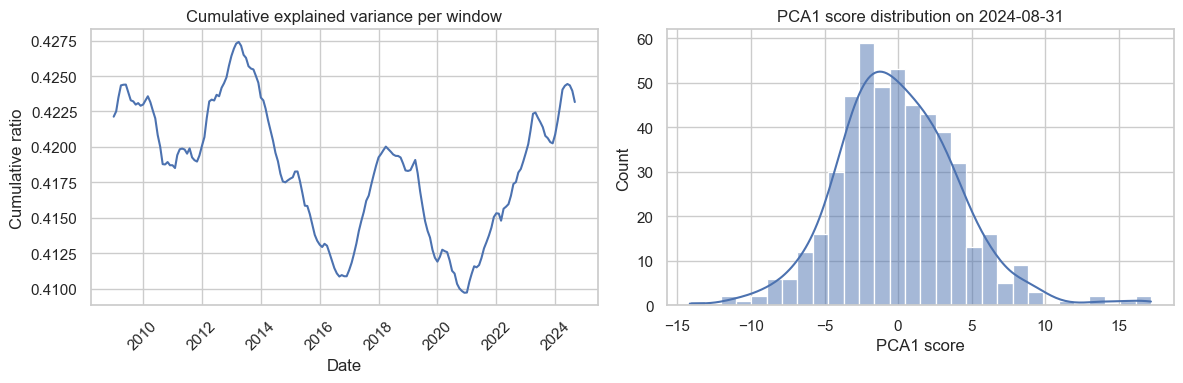

In [ ]:

# 6) Visualization diagnostics
latest_date = pca_scores.index.get_level_values("date").max()
latest_scores = pca_scores.xs(latest_date, level="date")

fig, axes = plt.subplots(1, 2, figsize=(12, 4))

# cumulative explained variance over time
sns.lineplot(data=var_df[[c for c in var_df.columns if c.startswith("pca_")]].cumsum(axis=1).iloc[:, -1], ax=axes[0])
axes[0].set_title("Cumulative explained variance per window")
axes[0].set_ylabel("Cumulative ratio")
axes[0].set_xlabel("Date")
axes[0].tick_params(axis='x', rotation=45)

# distribution of first PCA score on the latest date
sns.histplot(latest_scores["pca_1"], bins=30, kde=True, ax=axes[1])
axes[1].set_title(f"PCA1 score distribution on {latest_date.date()}")
axes[1].set_xlabel("PCA1 score")

plt.tight_layout()
plt.show()


In [ ]:

# 7) Feature loading inspection on the latest window
from sklearn.preprocessing import StandardScaler

# Refit PCA on the latest window to inspect loadings
latest_dates = sorted(processed.index.get_level_values("date").unique())[-ROLLING_WINDOW:]
window_df = processed.loc[pd.IndexSlice[latest_dates, :]]
valid_cols = window_df.columns[window_df.std() > 1e-8]
scaler = StandardScaler()
X = scaler.fit_transform(window_df[valid_cols])
pca_latest = PCA(n_components=min(N_COMPONENTS, len(valid_cols)), random_state=42)
pca_latest.fit(X)

loadings = pd.DataFrame(pca_latest.components_, columns=valid_cols, index=[f"pca_{i+1}" for i in range(pca_latest.n_components_)])

# Show top positive/negative contributors for PCA1
loadings_tidy = loadings.loc["pca_1"].sort_values()
print("Top negative contributors to PCA1:", loadings_tidy.head(10))
print("Top positive contributors to PCA1:", loadings_tidy.tail(10))


Top negative contributors to PCA1: fp_score                                  -0.128325
contributed_capital_to_total_mktcap_mrq   -0.113167
total_liab_to_total_asset_mrq             -0.083980
noa_to_noacap_mrq                         -0.076976
book_value_to_total_mktcap_mrq            -0.072224
market_downside_beta_252                  -0.067886
is_two_net_profit_negative_mra            -0.060342
sga_to_revenue_mra_yoy_chg                -0.057915
market_correlation_252                    -0.056230
adminexp_to_total_mktcap_ttm              -0.055677
Name: pca_1, dtype: float64
Top positive contributors to PCA1: basic_eps_mra                         0.156812
aqr_quality                           0.168868
aqr_profitability                     0.171506
deflated_gross_profit_to_asset_ttm    0.174958
return_on_net_operating_asset_ttm     0.176994
net_profit_to_asset2_mra              0.185626
operating_profit_to_book_value_ttm    0.196009
net_profit_to_book_value_ttm          0.200858
return